# Deep Ensemble (MNIST)

In [1]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset

# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
# def __init__(self, root, numbers=[0, 1], train=False, transform=None, limit=None):
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=10, transform=transform)

In [2]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=100,
        cache_size=25
    )

100%|██████████| 50/50 [03:50<00:00,  4.61s/it, loss=tensor(0.1314)]


In [3]:
test_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=1, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
outputs = ensemble.posterior_pred(test_loader, f_reg=False, mode=["mode","logits", "prob", "std"])

In [5]:
# Display rotated images
# num_images_to_display = 
idx_image_to_display = 10
i = 0
for images, labels in test_loader:
    img = images
    lbl = labels
    i += 1
    if i == idx_image_to_display:
        break

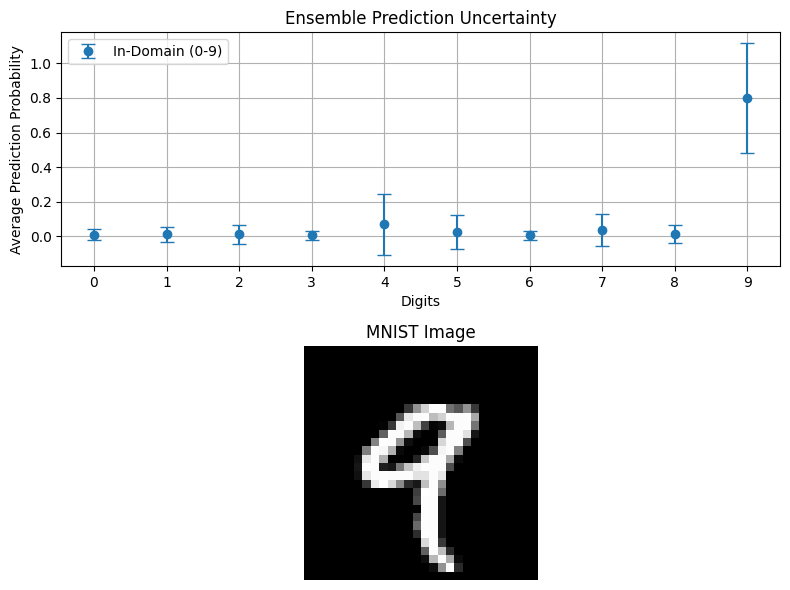

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# Sample average prediction probabilities and standard deviations
digits = np.arange(10)  # Digits 0-9
# avg_probs = np.array([0.92, 0.91, 0.93, 0.94, 0.92, 0.95, 0.94, 0.92, 0.93, 0.6])  # Sample average probs
# std_devs = np.array([0.03, 0.02, 0.03, 0.02, 0.03, 0.02, 0.03, 0.03, 0.03, 0.1])  # Sample std devs
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
# Plotting
plt.errorbar(digits, torch.mean(outputs["prob"], dim=1).squeeze()[9], yerr=outputs["std"][9], fmt='o', capsize=5, label='In-Domain (0-9)')

plt.xticks(digits)
plt.xlabel('Digits')
plt.ylabel('Average Prediction Probability')
plt.title('Ensemble Prediction Uncertainty')
plt.legend()
plt.grid(True)

# Second subplot for the MNIST image
plt.subplot(2, 1, 2)
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')  # Remove axis
plt.title('MNIST Image')

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()